Loading CSV (only feature columns)...
Loaded shape: (809642, 6)
Loading imputer and model...
Non-null per feature: {'blosum62_raw': 809642, 'hydropathy_diff': 809642, 'is_stop': 809642, 'grantham': 809642, 'af_filled': 809642, 'log_af': 809642}
Background rows: (50, 6) SHAP rows: (100, 6)
Running TreeExplainer (RandomForest) on small sample — this should be safe...
SHAP array shape: (100, 6)
Plotting SHAP beeswarm and mean-|SHAP|


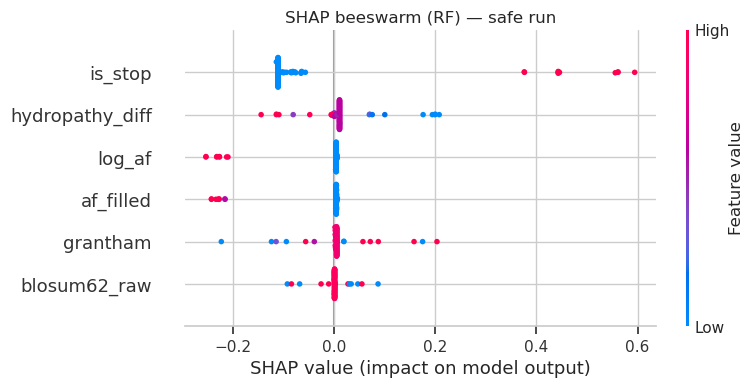

/tmp/ipykernel_701/3095930918.py:118: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="mean_abs_shap", y="feature", data=imp_df, palette="viridis")


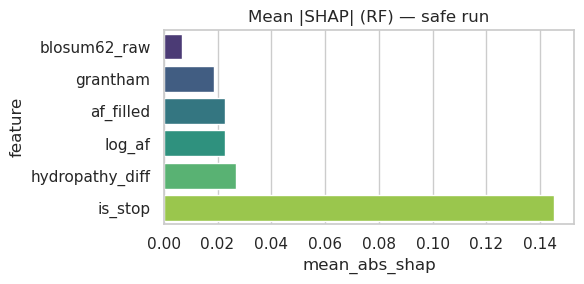

Plotting dependence for is_stop...


<Figure size 700x500 with 0 Axes>

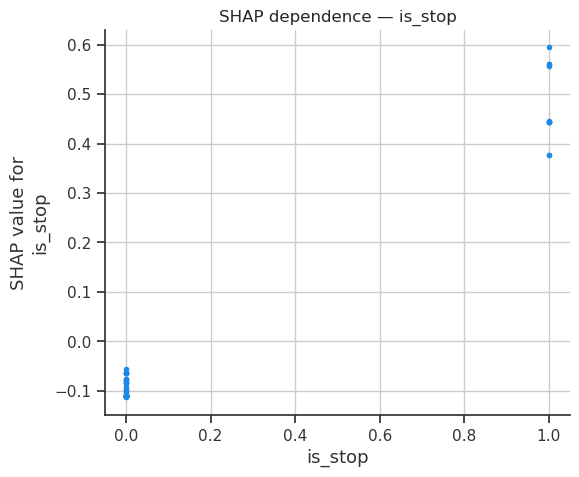

Saved: /mnt/c/Users/MYG-D02/variant-effect-prediction/results/shap_safe/depend_rf_is_stop.png
Plotting dependence for hydropathy_diff...


<Figure size 700x500 with 0 Axes>

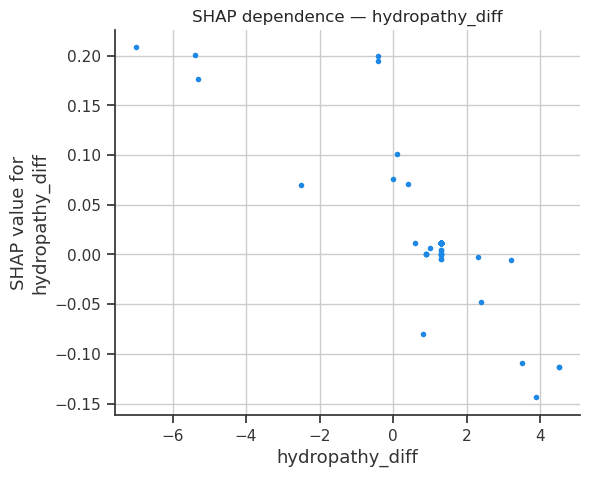

Saved: /mnt/c/Users/MYG-D02/variant-effect-prediction/results/shap_safe/depend_rf_hydropathy_diff.png
Plotting dependence for blosum62_raw...


<Figure size 700x500 with 0 Axes>

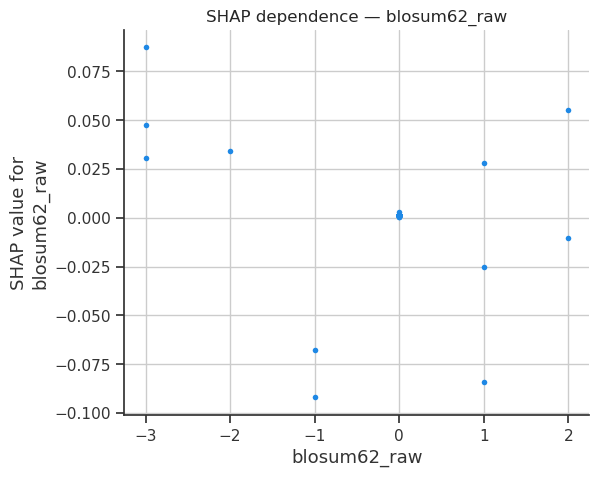

Saved: /mnt/c/Users/MYG-D02/variant-effect-prediction/results/shap_safe/depend_rf_blosum62_raw.png
Saved outputs to: /mnt/c/Users/MYG-D02/variant-effect-prediction/results/shap_safe


In [2]:
# SAFE SHAP RUN — very conservative to avoid OOM
import pandas as pd, numpy as np, joblib, gc, sys
from pathlib import Path
import shap, matplotlib.pyplot as plt, seaborn as sns
sns.set(style="whitegrid")

# Paths (adjust only if needed)
BASE = Path("/mnt/c/Users/MYG-D02/variant-effect-prediction/results")
CSV  = Path("/mnt/c/Users/MYG-D02/variant-effect-prediction/data/processed/clinvar_features_engineered.csv")
IMPUTER = BASE / "imputer.pkl"
SCALER  = BASE / "scaler.pkl"
RF_MODEL = BASE / "randomforest.pkl"   # prefer Tree model

OUT = BASE / "shap_safe"
OUT.mkdir(parents=True, exist_ok=True)

# Features (same as training)
FEATURES = ["blosum62_raw","hydropathy_diff","is_stop","grantham","af_filled","log_af"]

# Settings (very small)
BACKGROUND_N = 50   # reduce if memory limited
SAMPLE_N = 100      # <200 recommended for WSL
DOWNSAMPLE_FLOAT32 = True

print("Loading CSV (only feature columns)...")
df = pd.read_csv(CSV, usecols=lambda c: c in FEATURES, low_memory=False)
print("Loaded shape:", df.shape)

# load preproc + model
print("Loading imputer and model...")
imputer = joblib.load(IMPUTER)
rf = joblib.load(RF_MODEL)

# Impute and downcast (float32)
X_imp = pd.DataFrame(imputer.transform(df), columns=FEATURES, index=df.index)
if DOWNSAMPLE_FLOAT32:
    X_imp = X_imp.astype(np.float32)

# Quick check counts
print("Non-null per feature:", X_imp.notna().sum().to_dict())

# sample background and SHAP rows with deterministic RNG
rng = np.random.default_rng(42)
n_total = len(X_imp)
if n_total == 0:
    raise RuntimeError("No rows available in X_imp")

bg_n = min(BACKGROUND_N, n_total)
shap_n = min(SAMPLE_N, n_total)

bg_idx = rng.choice(n_total, size=bg_n, replace=False)
shap_idx = rng.choice(n_total, size=shap_n, replace=False)

X_bg = X_imp.iloc[bg_idx].reset_index(drop=True)
X_shap = X_imp.iloc[shap_idx].reset_index(drop=True)

print("Background rows:", X_bg.shape, "SHAP rows:", X_shap.shape)

# Garbage collect before heavy operation
gc.collect()

# Run TreeExplainer (fast + memory efficient)
try:
    print("Running TreeExplainer (RandomForest) on small sample — this should be safe...")
    expl = shap.TreeExplainer(rf, data=X_bg)
    raw_shap = expl.shap_values(X_shap)
    # coerce common shapes (class probs)
    arr = np.array(raw_shap) if not isinstance(raw_shap, np.ndarray) else raw_shap
    if isinstance(raw_shap, list):
        # choose class 1 if available
        arr = np.array(raw_shap[1]) if len(raw_shap) > 1 else np.array(raw_shap[0])
    if arr.ndim == 3 and arr.shape[2] >= 2:
        arr = arr[:,:,1]
    sv = arr
    # quick sanity
    print("SHAP array shape:", sv.shape)
except MemoryError as me:
    print("MemoryError during TreeExplainer:", me)
    print("Attempting extreme downsample: SAMPLE_N=50, BACKGROUND_N=20")
    import gc
    gc.collect()
    # try tiny
    bg_idx = rng.choice(n_total, size=min(20,n_total), replace=False)
    shap_idx = rng.choice(n_total, size=min(50,n_total), replace=False)
    X_bg = X_imp.iloc[bg_idx]
    X_shap = X_imp.iloc[shap_idx]
    expl = shap.TreeExplainer(rf, data=X_bg)
    raw_shap = expl.shap_values(X_shap)
    if isinstance(raw_shap, list):
        raw_shap = raw_shap[1] if len(raw_shap)>1 else raw_shap[0]
    sv = np.array(raw_shap)
except Exception as e:
    print("SHAP failed:", type(e), e)
    raise

# Convert to (n_samples, n_features) if needed
if sv.ndim == 3 and sv.shape[2] >= 2:
    sv = sv[:,:,1]
if sv.shape[0] != X_shap.shape[0] or sv.shape[1] != X_shap.shape[1]:
    try:
        sv = sv.reshape(X_shap.shape[0], X_shap.shape[1])
    except Exception as e:
        print("Could not reshape SHAP array:", e)
        raise

# Plot and save beeswarm + mean|SHAP|
print("Plotting SHAP beeswarm and mean-|SHAP|")
plt.figure(figsize=(8,5))
shap.summary_plot(sv, X_shap, show=False)
plt.title("SHAP beeswarm (RF) — safe run")
plt.savefig(OUT / "safe_beeswarm_rf.png", dpi=150, bbox_inches='tight')
plt.show()

mean_abs = np.abs(sv).mean(axis=0)
imp_df = pd.DataFrame({"feature": X_shap.columns, "mean_abs_shap": mean_abs}).sort_values("mean_abs_shap", ascending=True)
plt.figure(figsize=(6, max(3, 0.35*len(imp_df))))
import seaborn as sns
sns.barplot(x="mean_abs_shap", y="feature", data=imp_df, palette="viridis")
plt.title("Mean |SHAP| (RF) — safe run")
plt.tight_layout()
plt.savefig(OUT / "safe_meanabs_rf.png", dpi=150)
plt.show()

# --------------------
# SHAP DEPENDENCE PLOTS (SAFE)
# --------------------
DEPENDENCE_FEATURES = ["is_stop", "hydropathy_diff", "blosum62_raw"]

for feat in DEPENDENCE_FEATURES:
    if feat not in X_shap.columns:
        print(f"Skipping {feat} (not in X_shap)")
        continue

    try:
        print(f"Plotting dependence for {feat}...")
        plt.figure(figsize=(7,5))
        shap.dependence_plot(
            feat,
            sv,
            X_shap,
            interaction_index=None,   # avoid extra dimension problems
            show=False
        )
        plt.title(f"SHAP dependence — {feat}")
        outp = OUT / f"depend_rf_{feat}.png"
        plt.savefig(outp, dpi=150, bbox_inches="tight")
        plt.show()
        print("Saved:", outp)

    except Exception as e:
        print(f"Dependence plot failed for {feat}: {type(e)} {e}")


print("Saved outputs to:", OUT)


Dependence features present: ['is_stop', 'hydropathy_diff', 'blosum62_raw', 'grantham', 'af_filled', 'log_af']
Loaded rows: 809642
Using background: (50, 6) SHAP sample: (200, 6)

Processing model: RandomForest


<Figure size 700x500 with 0 Axes>

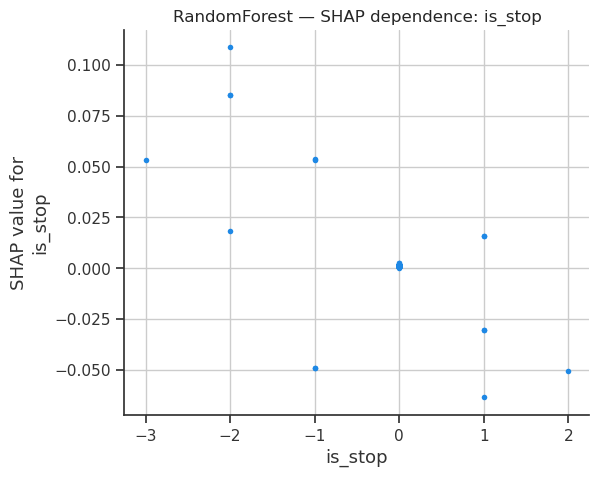

Saved: /mnt/c/Users/MYG-D02/variant-effect-prediction/results/shap_dependence_plots/depend_RandomForest_is_stop.png


<Figure size 700x500 with 0 Axes>

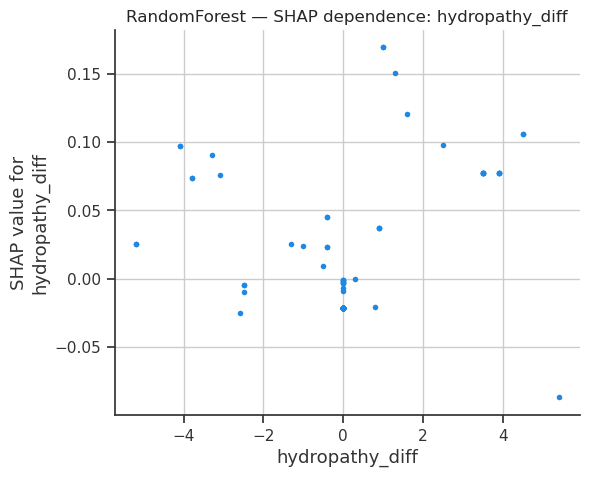

Saved: /mnt/c/Users/MYG-D02/variant-effect-prediction/results/shap_dependence_plots/depend_RandomForest_hydropathy_diff.png


<Figure size 700x500 with 0 Axes>

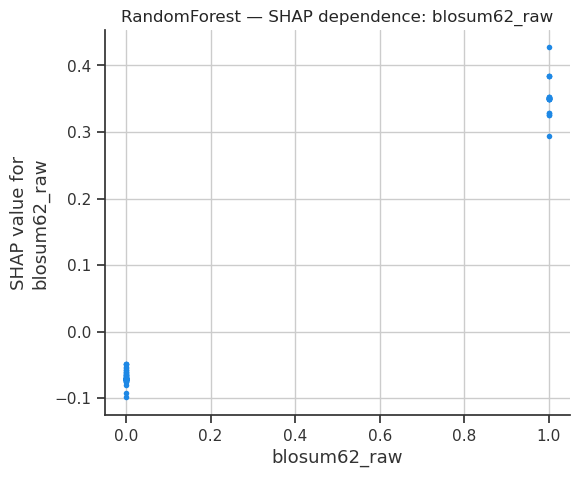

Saved: /mnt/c/Users/MYG-D02/variant-effect-prediction/results/shap_dependence_plots/depend_RandomForest_blosum62_raw.png


<Figure size 700x500 with 0 Axes>

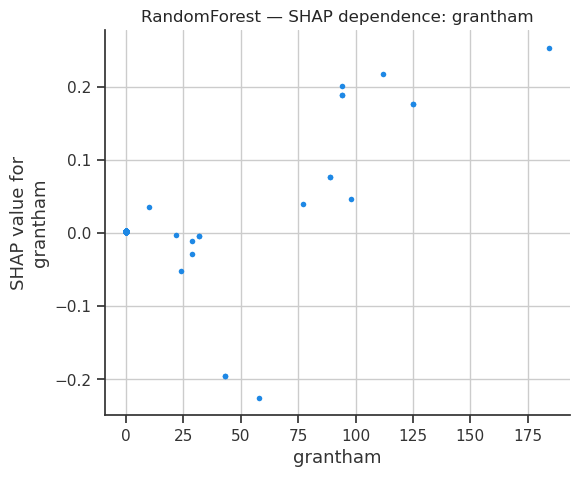

Saved: /mnt/c/Users/MYG-D02/variant-effect-prediction/results/shap_dependence_plots/depend_RandomForest_grantham.png


<Figure size 700x500 with 0 Axes>

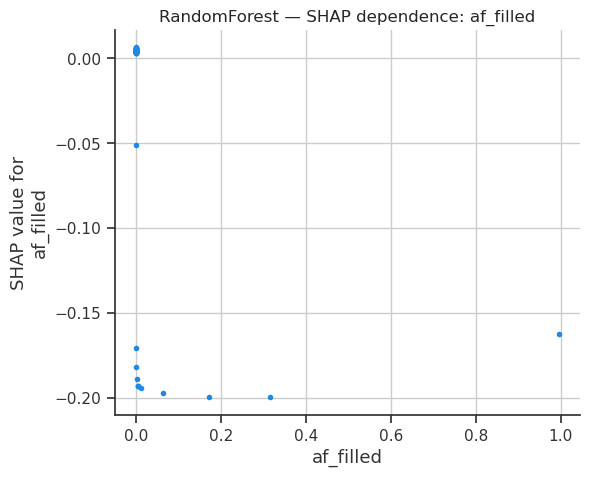

Saved: /mnt/c/Users/MYG-D02/variant-effect-prediction/results/shap_dependence_plots/depend_RandomForest_af_filled.png


<Figure size 700x500 with 0 Axes>

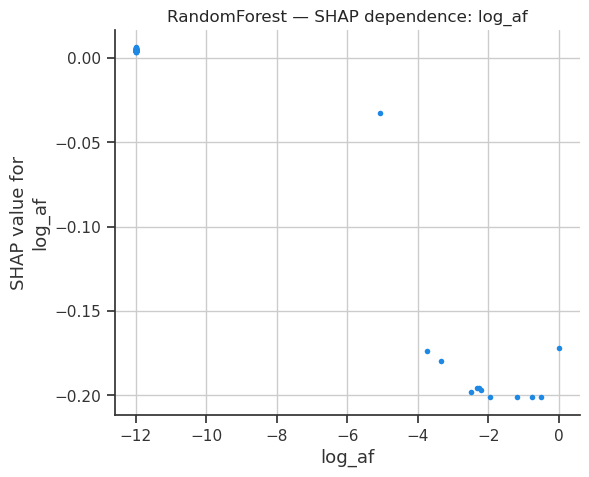

Saved: /mnt/c/Users/MYG-D02/variant-effect-prediction/results/shap_dependence_plots/depend_RandomForest_log_af.png

Processing model: XGBoost
General SHAP error for XGBoost : <class 'ValueError'> could not convert string to float: '[4.7871876E-1]'

Processing model: LogisticRegression
General SHAP error for LogisticRegression : <class 'ValueError'> The feature names should match those that were passed during fit.
Feature names must be in the same order as they were in fit.


Done. Dependence plots saved to: /mnt/c/Users/MYG-D02/variant-effect-prediction/results/shap_dependence_plots


In [3]:
# SAFE: SHAP dependence plots for additional features (grantham, af_filled, log_af, etc.)
import pandas as pd, numpy as np, joblib, gc
from pathlib import Path
import shap, matplotlib.pyplot as plt, seaborn as sns
sns.set(style="whitegrid")

# ---------- PATHS (update if different) ----------
BASE = Path("/mnt/c/Users/MYG-D02/variant-effect-prediction/results")
CSV  = Path("/mnt/c/Users/MYG-D02/variant-effect-prediction/data/processed/clinvar_features_engineered.csv")
IMPUTER = BASE / "imputer.pkl"
SCALER  = BASE / "scaler.pkl"
RF_MODEL = BASE / "randomforest.pkl"
XGB_MODEL = BASE / "xgboost.pkl"
LR_MODEL = BASE / "logisticregression.pkl"
OUT = BASE / "shap_dependence_plots"
OUT.mkdir(parents=True, exist_ok=True)

# ---------- FEATURES to plot ----------
DEP_FEATS = ["is_stop","hydropathy_diff","blosum62_raw","grantham","af_filled","log_af"]

# ---------- load CSV (only needed columns) ----------
available_cols = set(pd.read_csv(CSV, nrows=1).columns)
use_cols = [c for c in DEP_FEATS if c in available_cols]
if len(use_cols) == 0:
    raise RuntimeError(f"None of the dependence features present in CSV. CSV columns: {list(available_cols)[:30]}")

print("Dependence features present:", use_cols)

# load data and preprocess
df = pd.read_csv(CSV, usecols=lambda c: c in use_cols, low_memory=False)
print("Loaded rows:", len(df))

# load preproc + models
imputer = joblib.load(IMPUTER)
scaler  = joblib.load(SCALER)    # scaler used for LR
rf = joblib.load(RF_MODEL)
xgb = joblib.load(XGB_MODEL) if XGB_MODEL.exists() else None
lr  = joblib.load(LR_MODEL)

# ---------- prepare small safe samples ----------
# impute and downcast to float32 for memory safety
X_imp_all = pd.DataFrame(imputer.transform(df.fillna(0)), columns=use_cols, index=df.index).astype(np.float32)

# deterministic rng
rng = np.random.default_rng(42)
n_total = len(X_imp_all)
if n_total == 0:
    raise RuntimeError("No rows available for SHAP.")

BG = min(50, n_total)     # background rows
SH = min(200, n_total)    # shap sample rows (200 is already conservative)
bg_idx = rng.choice(n_total, size=BG, replace=False)
shap_idx = rng.choice(n_total, size=SH, replace=False)

X_bg = X_imp_all.iloc[bg_idx].reset_index(drop=True)
X_shap = X_imp_all.iloc[shap_idx].reset_index(drop=True)

print("Using background:", X_bg.shape, "SHAP sample:", X_shap.shape)

gc.collect()

# ---------- helper to coerce shap arrays ----------
def fix_shap_array(raw_shap, n_samples, n_features):
    arr = raw_shap
    if isinstance(arr, list):
        # usually [class0, class1] for binary -> pick class1
        arr = arr[1] if len(arr) > 1 else arr[0]
    arr = np.array(arr)
    if arr.ndim == 3 and arr.shape[2] >= 2:
        arr = arr[:,:,1]
    if arr.ndim == 3 and arr.shape[2] == 1:
        arr = arr[:,:,0]
    if arr.size == n_samples * n_features:
        return arr.reshape(n_samples, n_features)
    if arr.shape == (n_samples, n_features):
        return arr
    return None

# ---------- FUNCTION to compute SHAP and plot dependencies for one model ----------
def shap_dependence_for_model(model, model_name, X_background, X_sample, features_list, scaled_for_lr=False, scaler_obj=None):
    print("\nProcessing model:", model_name)
    try:
        if "Logistic" in model_name or "logistic" in model_name.lower():
            # Logistic: use LinearExplainer on scaled data if scaler available
            if scaler_obj is None:
                print("Scaler not provided for Logistic — attempting LinearExplainer on unscaled input (may be inaccurate).")
                Xb = X_background
                Xs = X_sample
            else:
                Xb = pd.DataFrame(scaler_obj.transform(X_background), columns=features_list)
                Xs = pd.DataFrame(scaler_obj.transform(X_sample), columns=features_list)
            try:
                expl = shap.LinearExplainer(model, Xb, feature_dependence="independent")
                raw_shap = expl.shap_values(Xs)
            except Exception as e:
                print("LinearExplainer failed, falling back to KernelExplainer (slower):", e)
                expl = shap.KernelExplainer(lambda z: model.predict_proba(z)[:,1], Xb.iloc[:min(20,len(Xb))])
                raw_shap = expl.shap_values(Xs, nsamples=100)
        else:
            # tree models: use TreeExplainer on imputed (unscaled) data
            expl = shap.TreeExplainer(model, data=X_background)
            raw_shap = expl.shap_values(X_sample)

        sv = fix_shap_array(raw_shap, X_sample.shape[0], X_sample.shape[1])
        if sv is None:
            print("Could not coerce SHAP array for", model_name)
            return

        # For each dependence feature requested, draw dependence plot if present
        for feat in features_list:
            if feat not in X_sample.columns:
                print("Skipping dependence for", feat, "- not present in sample")
                continue
            try:
                # shap.dependence_plot expects shap_values array aligned with X_sample columns
                plt.figure(figsize=(7,5))
                shap.dependence_plot(feat, sv, X_sample, interaction_index=None, show=False)
                plt.title(f"{model_name} — SHAP dependence: {feat}")
                outp = OUT / f"depend_{model_name}_{feat}.png"
                plt.savefig(outp, dpi=140, bbox_inches="tight")
                plt.show()
                print("Saved:", outp)
            except Exception as e:
                print("Dependence plot failed for", feat, ":", type(e), e)

    except MemoryError as me:
        print("MemoryError computing SHAP for", model_name, me)
    except Exception as e:
        print("General SHAP error for", model_name, ":", type(e), e)

# ---------- RUN for RF (preferred) ----------
shap_dependence_for_model(rf, "RandomForest", X_bg, X_shap, use_cols, scaled_for_lr=False, scaler_obj=None)

# ---------- RUN for XGBoost if exists ----------
if xgb is not None:
    shap_dependence_for_model(xgb, "XGBoost", X_bg, X_shap, use_cols, scaled_for_lr=False, scaler_obj=None)
else:
    print("XGBoost model not found; skipped.")

# ---------- RUN for LR (scaled) ----------
if scaler is not None:
    # use same features order as X_shap
    shap_dependence_for_model(lr, "LogisticRegression", X_bg, X_shap, use_cols, scaled_for_lr=True, scaler_obj=scaler)
else:
    print("Scaler not found — running Logistic SHAP without scaler (may be inaccurate).")
    shap_dependence_for_model(lr, "LogisticRegression", X_bg, X_shap, use_cols, scaled_for_lr=False, scaler_obj=None)

print("\nDone. Dependence plots saved to:", OUT)


Loading header to validate columns...
Loading relevant columns (fast)...
Full dataset rows: 809642
Stratified subsample to 40000 rows for speed.
Working rows: 40000
Training XGBoost on subsample (this should be fast)...
Saving model to: /mnt/c/Users/MYG-D02/variant-effect-prediction/results/xgboost.json and /mnt/c/Users/MYG-D02/variant-effect-prediction/results/xgboost.pkl

Metrics (threshold 0.5):
Accuracy: 0.6508, Precision: 0.9011, Recall: 0.3026, F1: 0.4530
ROC AUC: 0.6914, PR AUC (Average Precision): 0.6667

Classification report:
               precision    recall  f1-score   support

           0     0.6029    0.9696    0.7435      4176
           1     0.9011    0.3026    0.4530      3824

    accuracy                         0.6508      8000
   macro avg     0.7520    0.6361    0.5982      8000
weighted avg     0.7454    0.6508    0.6046      8000



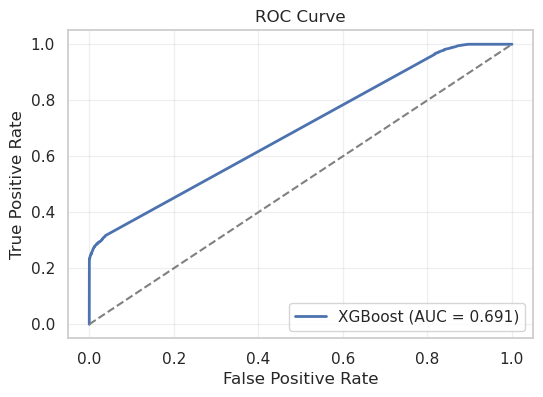

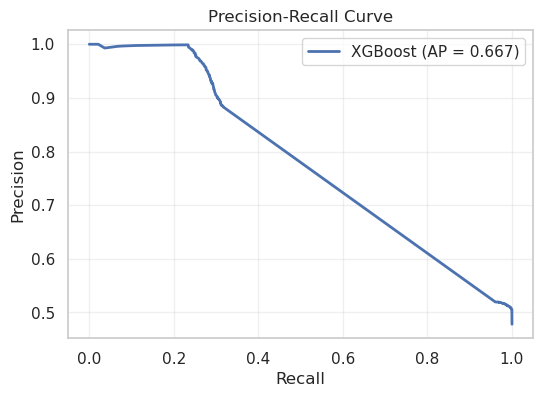

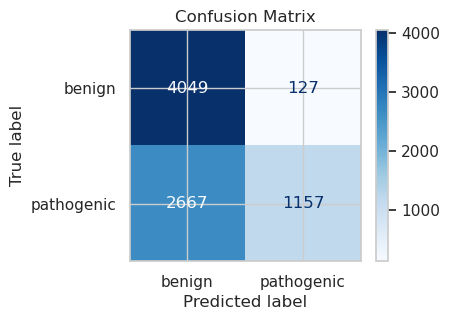

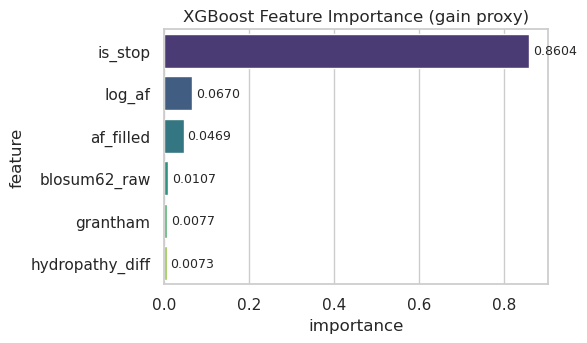


Done — model and plots saved to: /mnt/c/Users/MYG-D02/variant-effect-prediction/results
Model JSON: /mnt/c/Users/MYG-D02/variant-effect-prediction/results/xgboost.json
Model pickle: /mnt/c/Users/MYG-D02/variant-effect-prediction/results/xgboost.pkl
Plots directory: /mnt/c/Users/MYG-D02/variant-effect-prediction/results/eval_plots


In [12]:
# QUICK retrain (subsample) + evaluation (ROC, PR, Confusion Matrix, Feature Importance)
# Safe, fast: stratified subsample to MAX_ROWS to avoid long runtimes
import warnings
warnings.filterwarnings("ignore")

import pandas as pd, numpy as np, joblib, gc
from pathlib import Path
import matplotlib.pyplot as plt, seaborn as sns
sns.set(style="whitegrid")
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_auc_score, roc_curve, precision_recall_curve,
                             average_precision_score, accuracy_score, precision_score,
                             recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report)
from xgboost import XGBClassifier

# Paths
CSV_PATH = Path("/mnt/c/Users/MYG-D02/variant-effect-prediction/data/processed/clinvar_features_engineered.csv")   # uploaded CSV (fast local copy)
OUT_DIR = Path("/mnt/c/Users/MYG-D02/variant-effect-prediction/results")
OUT_DIR.mkdir(parents=True, exist_ok=True)
MODEL_JSON = OUT_DIR / "xgboost.json"
MODEL_PKL  = OUT_DIR / "xgboost.pkl"
PLOTS_DIR  = OUT_DIR / "eval_plots"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

# Features & label
FEATURES = ["blosum62_raw","hydropathy_diff","is_stop","grantham","af_filled","log_af"]
LABEL_COL = "label_numeric"

# Fast subsample cap (reduce to 20k if you want even faster)
MAX_ROWS = 40000

print("Loading header to validate columns...")
head = pd.read_csv(CSV_PATH, nrows=1)
missing = [c for c in FEATURES + [LABEL_COL] if c not in head.columns]
if missing:
    raise RuntimeError(f"CSV missing required columns: {missing}. Columns available: {list(head.columns)}")

print("Loading relevant columns (fast)...")
df = pd.read_csv(CSV_PATH, usecols=FEATURES + [LABEL_COL], low_memory=False)
print("Full dataset rows:", len(df))

# Clean / impute
for c in FEATURES:
    df[c] = pd.to_numeric(df[c], errors='coerce')
df[LABEL_COL] = pd.to_numeric(df[LABEL_COL], errors='coerce')
df = df[df[LABEL_COL].notna()].copy()
imp = SimpleImputer(strategy="median")
df[FEATURES] = imp.fit_transform(df[FEATURES])
df[LABEL_COL] = df[LABEL_COL].astype(int)

# Subsample stratified if large
if len(df) > MAX_ROWS:
    print(f"Stratified subsample to {MAX_ROWS} rows for speed.")
    frac = MAX_ROWS / len(df)
    df = df.groupby(LABEL_COL, group_keys=False).apply(lambda x: x.sample(frac=frac, random_state=42)).reset_index(drop=True)
    # ensure exact size
    if len(df) > MAX_ROWS:
        df = df.sample(n=MAX_ROWS, random_state=42).reset_index(drop=True)
print("Working rows:", len(df))

# Train/test split
X = df[FEATURES]
y = df[LABEL_COL]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

# Train XGBoost (SHAP-safe)
xgb = XGBClassifier(
    n_estimators=250,
    learning_rate=0.08,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.9,
    use_label_encoder=False,
    eval_metric="logloss",
    base_score=0.5,
    random_state=42,
    n_jobs=4,
    verbosity=0
)

print("Training XGBoost on subsample (this should be fast)...")
xgb.fit(X_train, y_train)

# Save model (native JSON + pickle)
print("Saving model to:", MODEL_JSON, "and", MODEL_PKL)
xgb.get_booster().save_model(str(MODEL_JSON))
joblib.dump(xgb, MODEL_PKL)

# Evaluate
y_prob = xgb.predict_proba(X_test)[:,1]
y_pred = (y_prob >= 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
ap  = average_precision_score(y_test, y_prob)

print("\nMetrics (threshold 0.5):")
print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")
print(f"ROC AUC: {auc:.4f}, PR AUC (Average Precision): {ap:.4f}")
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=4))

# ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {auc:.3f})", linewidth=2)
plt.plot([0,1],[0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.savefig(PLOTS_DIR / "roc_xgb.png", dpi=150, bbox_inches="tight")
plt.show()

# Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(6,4))
plt.plot(recall, precision, label=f"XGBoost (AP = {ap:.3f})", linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="upper right")
plt.grid(alpha=0.3)
plt.savefig(PLOTS_DIR / "pr_xgb.png", dpi=150, bbox_inches="tight")
plt.show()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(4,3))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["benign","pathogenic"])
disp.plot(cmap="Blues", values_format="d", ax=ax)
plt.title("Confusion Matrix")
plt.savefig(PLOTS_DIR / "confusion_xgb.png", dpi=150, bbox_inches="tight")
plt.show()

# Feature importance (built-in)
fi = xgb.feature_importances_
fi_df = pd.DataFrame({"feature": FEATURES, "importance": fi}).sort_values("importance", ascending=False)
plt.figure(figsize=(6, max(2, 0.6*len(fi_df))))
sns.barplot(x="importance", y="feature", data=fi_df, palette="viridis")
plt.title("XGBoost Feature Importance (gain proxy)")
for i, v in enumerate(fi_df["importance"].values):
    plt.text(v + max(fi_df["importance"].max()*0.01, 1e-6), i, f"{v:.4f}", va="center", fontsize=9)
plt.tight_layout()
plt.savefig(PLOTS_DIR / "fi_xgb.png", dpi=150)
plt.show()

# Save metrics
metrics = {
    "model": "xgboost",
    "accuracy": acc, "precision": prec, "recall": rec, "f1": f1,
    "roc_auc": auc, "pr_auc": ap, "n_train": len(X_train), "n_test": len(X_test)
}
pd.DataFrame([metrics]).to_csv(OUT_DIR / "xgb_eval_metrics.csv", index=False)

print("\nDone — model and plots saved to:", OUT_DIR)
print("Model JSON:", MODEL_JSON)
print("Model pickle:", MODEL_PKL)
print("Plots directory:", PLOTS_DIR)
